# TSAI Assignment 10

Import Headers

In [1]:
from __future__ import print_function
from utils import torch,nn,F,optim,datasets,transforms
import utils
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Create Train and test Transforms - use Albumentations module

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

train_transforms = A.Compose(
    [           
        A.augmentations.transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1, always_apply=False, p = 0.5),       
        A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
        A.RandomCrop(height=32, width=32, always_apply=True),
        A.HorizontalFlip(),
        
        A.Normalize(mean=means, std=stds, always_apply=True),
        A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=means,  always_apply=True),       
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.Normalize(mean=means, std=stds, always_apply=True),
        ToTensorV2(),
    ]
)

In [4]:
class Cifar10SearchDataset(datasets.CIFAR10):

    def __init__(self, root="~/data", train=True, download=True, transform=None):

        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):

        image, label = self.data[index], self.targets[index]

        if self.transform is not None:

            transformed = self.transform(image=image)

            image = transformed["image"]

        return image, label

Get the CIFAR 10 data - train dataset and test dataset

In [5]:
train = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


Get the train_loader and test_loader -  batches of data used in model training/testing

In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

Print the train dataset after transforms

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


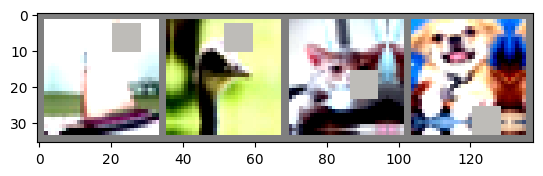

ship  bird  cat   dog  


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Get the custom resnet model

In [8]:
import custom_resnet
myFirstModel = custom_resnet.getModel()

Print Model Summary

In [9]:
utils.printModelSummary(myFirstModel,(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
           Dropout-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
          Dropout-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

Use LR Finder to get Max LR 

C:\Users\SToleti\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_lr_finder\lr_finder.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
 60%|████████████████████████████████████████████████▍                               | 121/200 [02:35<01:41,  1.28s/it]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 5.87E-02


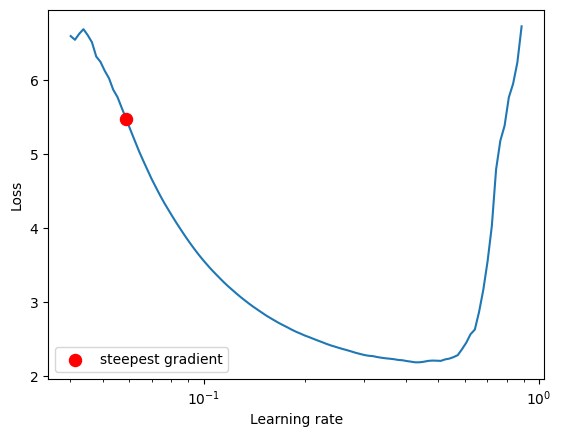

In [10]:
from torch_lr_finder import LRFinder
model = myFirstModel
optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

Model Training

In [11]:
from torch.optim.lr_scheduler import OneCycleLR

# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

num_epochs = 24

scheduler = OneCycleLR(
        optimizer,
        max_lr= 4.51E-02, #6.41E-02,
        steps_per_epoch=len(train_loader),
        epochs=num_epochs,
        pct_start=5/num_epochs,
        div_factor=80,
        three_phase=False,
        final_div_factor=550,
        verbose =False,
    )

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  tr_Acc, tr_loss = utils.train(myFirstModel, train_loader, optimizer, criterion, scheduler)
  tst_acc, tst_loss = utils.test(myFirstModel, test_loader, criterion)
  train_acc.append(tr_Acc)
  train_losses.append(tr_loss)
  test_acc.append(tst_acc)
  test_losses.append(tst_loss)
  print(f'LR = {scheduler.get_last_lr()}')
  #scheduler.step()
  #scheduler.step()

Epoch 1


Train: Loss=1.2928 Batch_id=97 Accuracy=43.19: 100%|███████████████████████████████████| 98/98 [00:47<00:00,  2.08it/s]


Test set: Average loss: 0.0025, Accuracy: 5517/10000 (55.17%)

LR = [0.004833416270109775]
Epoch 2


Train: Loss=1.0840 Batch_id=97 Accuracy=59.28: 100%|███████████████████████████████████| 98/98 [00:46<00:00,  2.10it/s]


Test set: Average loss: 0.0021, Accuracy: 6370/10000 (63.70%)

LR = [0.016005092669314405]
Epoch 3


Train: Loss=0.9610 Batch_id=97 Accuracy=64.61: 100%|███████████████████████████████████| 98/98 [00:46<00:00,  2.10it/s]


Test set: Average loss: 0.0018, Accuracy: 6796/10000 (67.96%)

LR = [0.029794688830574404]
Epoch 4


Train: Loss=0.7763 Batch_id=97 Accuracy=70.56: 100%|███████████████████████████████████| 98/98 [00:46<00:00,  2.10it/s]


Test set: Average loss: 0.0021, Accuracy: 6250/10000 (62.50%)

LR = [0.04091420016363649]
Epoch 5


Train: Loss=0.7805 Batch_id=97 Accuracy=71.43: 100%|███████████████████████████████████| 98/98 [00:46<00:00,  2.10it/s]


Test set: Average loss: 0.0016, Accuracy: 7328/10000 (73.28%)

LR = [0.04509996790429134]
Epoch 6


Train: Loss=0.7906 Batch_id=97 Accuracy=72.57: 100%|███████████████████████████████████| 98/98 [00:46<00:00,  2.09it/s]


Test set: Average loss: 0.0017, Accuracy: 7158/10000 (71.58%)

LR = [0.044786160591525584]
Epoch 7


Train: Loss=0.8717 Batch_id=97 Accuracy=72.73: 100%|███████████████████████████████████| 98/98 [00:46<00:00,  2.09it/s]


Test set: Average loss: 0.0016, Accuracy: 7290/10000 (72.90%)

LR = [0.043865822762831526]
Epoch 8


Train: Loss=0.7726 Batch_id=97 Accuracy=73.67: 100%|███████████████████████████████████| 98/98 [00:47<00:00,  2.08it/s]


Test set: Average loss: 0.0015, Accuracy: 7475/10000 (74.75%)

LR = [0.042364058835034274]
Epoch 9


Train: Loss=0.8078 Batch_id=97 Accuracy=73.35: 100%|███████████████████████████████████| 98/98 [00:46<00:00,  2.10it/s]


Test set: Average loss: 0.0016, Accuracy: 7227/10000 (72.27%)

LR = [0.04032183301327774]
Epoch 10


Train: Loss=0.8254 Batch_id=97 Accuracy=73.67: 100%|███████████████████████████████████| 98/98 [00:46<00:00,  2.09it/s]


Test set: Average loss: 0.0017, Accuracy: 6874/10000 (68.74%)

LR = [0.03779485189429408]
Epoch 11


Train: Loss=0.7213 Batch_id=97 Accuracy=74.76: 100%|███████████████████████████████████| 98/98 [00:46<00:00,  2.09it/s]


Test set: Average loss: 0.0018, Accuracy: 6995/10000 (69.95%)

LR = [0.034852044935661]
Epoch 12


Train: Loss=0.6397 Batch_id=97 Accuracy=74.93: 100%|███████████████████████████████████| 98/98 [00:47<00:00,  2.08it/s]


Test set: Average loss: 0.0015, Accuracy: 7396/10000 (73.96%)

LR = [0.031573684239884825]
Epoch 13


Train: Loss=0.7705 Batch_id=97 Accuracy=76.13: 100%|███████████████████████████████████| 98/98 [00:47<00:00,  2.07it/s]


Test set: Average loss: 0.0014, Accuracy: 7585/10000 (75.85%)

LR = [0.028049194940697814]
Epoch 14


Train: Loss=0.6839 Batch_id=97 Accuracy=76.29: 100%|███████████████████████████████████| 98/98 [00:47<00:00,  2.08it/s]


Test set: Average loss: 0.0015, Accuracy: 7442/10000 (74.42%)

LR = [0.024374715918523894]
Epoch 15


Train: Loss=0.6008 Batch_id=97 Accuracy=77.31: 100%|███████████████████████████████████| 98/98 [00:46<00:00,  2.09it/s]


Test set: Average loss: 0.0013, Accuracy: 7869/10000 (78.69%)

LR = [0.020650477382436045]
Epoch 16


Train: Loss=0.6084 Batch_id=97 Accuracy=78.20: 100%|███████████████████████████████████| 98/98 [00:47<00:00,  2.07it/s]


Test set: Average loss: 0.0011, Accuracy: 8203/10000 (82.03%)

LR = [0.01697806685133345]
Epoch 17


Train: Loss=0.5893 Batch_id=97 Accuracy=79.32: 100%|███████████████████████████████████| 98/98 [00:47<00:00,  2.05it/s]


Test set: Average loss: 0.0011, Accuracy: 8187/10000 (81.87%)

LR = [0.013457658111244816]
Epoch 18


Train: Loss=0.5205 Batch_id=97 Accuracy=80.86: 100%|███████████████████████████████████| 98/98 [00:47<00:00,  2.06it/s]


Test set: Average loss: 0.0009, Accuracy: 8558/10000 (85.58%)

LR = [0.010185278735579093]
Epoch 19


Train: Loss=0.4341 Batch_id=97 Accuracy=82.38: 100%|███████████████████████████████████| 98/98 [00:47<00:00,  2.07it/s]


Test set: Average loss: 0.0009, Accuracy: 8511/10000 (85.11%)

LR = [0.007250190703248084]
Epoch 20


Train: Loss=0.4310 Batch_id=97 Accuracy=84.32: 100%|███████████████████████████████████| 98/98 [00:47<00:00,  2.06it/s]


Test set: Average loss: 0.0007, Accuracy: 8820/10000 (88.20%)

LR = [0.004732455564570286]
Epoch 21


Train: Loss=0.3491 Batch_id=97 Accuracy=85.96: 100%|███████████████████████████████████| 98/98 [00:48<00:00,  2.03it/s]


Test set: Average loss: 0.0006, Accuracy: 8899/10000 (88.99%)

LR = [0.002700750570883186]
Epoch 22


Train: Loss=0.4107 Batch_id=97 Accuracy=87.64: 100%|███████████████████████████████████| 98/98 [00:47<00:00,  2.06it/s]


Test set: Average loss: 0.0006, Accuracy: 8977/10000 (89.77%)

LR = [0.001210495338154913]
Epoch 23


Train: Loss=0.3193 Batch_id=97 Accuracy=88.81: 100%|███████████████████████████████████| 98/98 [00:48<00:00,  2.03it/s]


Test set: Average loss: 0.0006, Accuracy: 9053/10000 (90.53%)

LR = [0.00030234014432884896]
Epoch 24


Train: Loss=0.3124 Batch_id=97 Accuracy=89.50: 100%|███████████████████████████████████| 98/98 [00:47<00:00,  2.06it/s]


Test set: Average loss: 0.0006, Accuracy: 9063/10000 (90.63%)

LR = [1.0570957086617859e-06]


Plot Model Test and Train accuracy

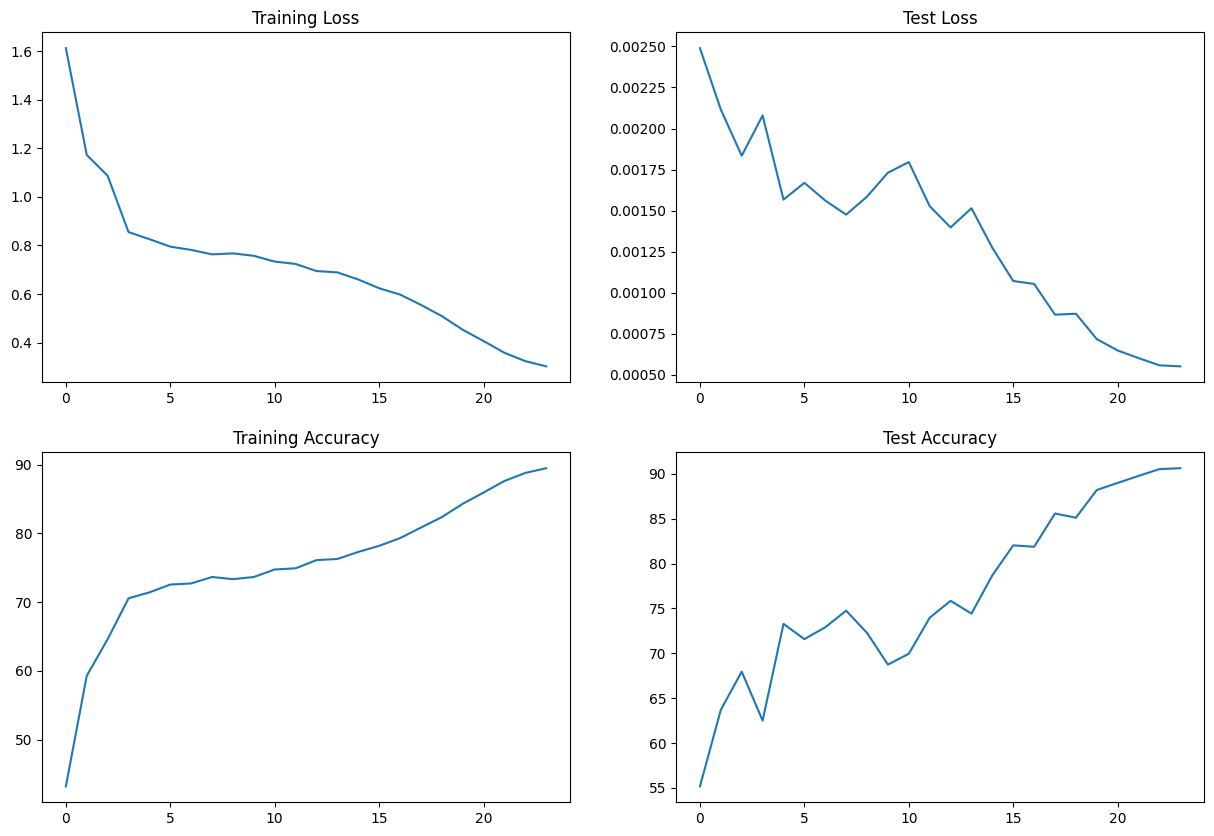

In [12]:
utils.printModelTrainTestAccuracy(train_acc, train_losses, test_acc, test_losses)